# Aspirin Hydrolysis Curve Fits

the data is from 
"The hydrolysis of aspirin." L.J. Edwards, *Trans. Faraday Soc.*, **1950**, *46*, 723-735. https://doi.org/10.1039/TF9504600723

## Load Data

The data table from the above paper was made into a csv file (`Edwards1950.csv`). The file contains pH and k_obs values. It is read into a dataframe with the pH va;ues as the index series.  Then a $\log{(K_{obs})}$ series is created and a series for $[H^+]$

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import linregress
from scipy.optimize import curve_fit

import uncertainties as un               # tool set for handling uncertainties
from uncertainties import unumpy as unp  # a replacement for numpy 

!mkdir plots

################################################################################
### Set global variables. Set flag accordingly
################################################################################

#github = True  
github = False  

if github:
    data_path = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_10/data/"
    image_path = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_10/images/"
    github_data_location = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"
    github_styles_location = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
else:
    data_path = "../Class_10/data/"
    image_path = "../Class_10/images/"
    github_data_location = "/Users/blink/github/LFER-QSAR/data/"
    github_styles_location = "/Users/blink/github/LFER-QSAR/styles/"

################################################################################
### Read data set. The fields are separated by commas; comments are enabled  
################################################################################

df = pd.read_csv(data_path + "Edwards1950.csv", 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="pH", 
                 comment = "#") 

################################################################################
### Process data  
################################################################################

df["logk"] = np.log10(df["k_obs"])        # get log(K) from K
df["H"]=10**(-df.index)                   # get [H] from pH
df.sort_values(by=['pH'], inplace=True)   # one value was out of order, sort to fix.

# display(df)

mkdir: plots: File exists


## Plot the Data

Below is code that will plot the log-log plot for the pH-rate profile. We will plot $\log{k_{obs}}$ vs. $pH$

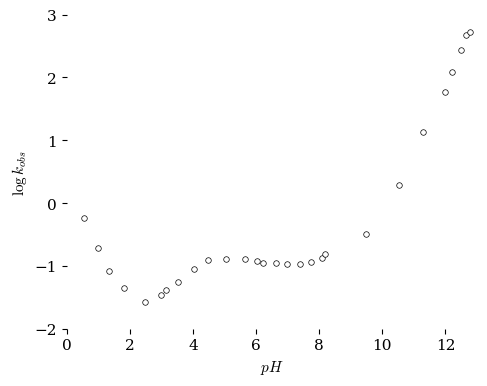

In [22]:
################################################################################
### Choose x and y for plot
################################################################################

x = df.index
y = np.array(df["logk"])

################################################################################
### Setup a figure with two plots side-by-side and choose a stylesheet
################################################################################

plt.style.use(github_styles_location + "tufte.mplstyle")        
#plt.style.use(github_styles_location + "S2_classic2.mplstyle")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  

################################################################################
### Plot the data    
################################################################################

ax.scatter(x, y, 
           marker = "o", s=16, 
           color="white", edgecolor = "black",
           linewidth = 0.5, zorder=3)
   
################################################################################
### Set labels and scale 
################################################################################

ax.set(ylabel=r"$\log{k_{obs}}$", 
       xlabel=r"$pH$",
       xlim=[0,13],                  
       ylim=[-2,3],     
      )
#ax.margins(x=.07, y=.07, tight=True)      # add 7% empty space around outside of plot area   

################################################################################
### Output the final plot 
################################################################################

fig.savefig("plots/01_plot_pH.pdf")   # use this to save the figure in PDF format
plt.show()                            # output the plot to the screen

## The Components of the pH-rate Profile

There are at least three, perhaps four, reactions that contribute to the observed rate constant, $k_{obs}$. In the plot below we will fit each to the region of the plot that applies and find the values of the individual rate constants in piecemeal fashion. See the discussion document for more information.

k^AH2_H2O = 1.87985+/-0.05127
k^A-_HO- = 7970.652+/-666.734
pKa, k^AH_H2O = 3.55+/-0.08, 0.11874+/-0.00384


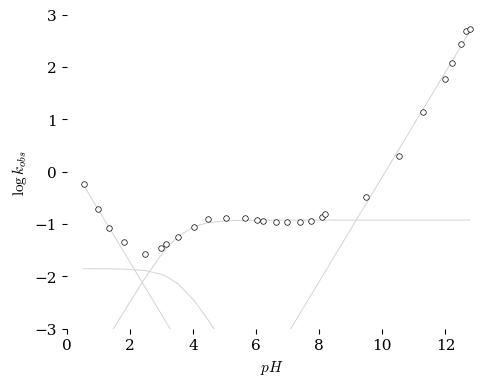

In [23]:
################################################################################
### Choose x and y for plot
################################################################################

x = df.index
y = np.array(df["logk"])

################################################################################
### Functions that define each component's rate constant
################################################################################

def genbase(pH_list, pKa, kobs): # fit the intramolecular general base-catalyzed rate
#    Ka = 10**(-3.6)
    Ka = 10**(-pKa)
    H_list = 10**(-pH_list)
    rate = Ka/(Ka + H_list)*kobs
    return np.log10(rate)

def genacid(pH_list, pKa, kobs): # fit the water rate (kinetically indistiguishable from GA)
    Ka = 10**(-pKa)
    H_list = 10**(-pH_list)
    rate = (H_list/(Ka + H_list)*kobs)
    return np.log10(rate)

def specificacid(pH_list, k):   # fit the specific acid-catalyzed rate 
    H_list = 10**(-pH_list)
    rate = (H_list*k)
    return np.log10(rate)    
    
def specificbase(pH_list, k):  # fit the specific base-catalyzed rate
    H_list = 10**(-pH_list)
    OH_list = (10**(-14)) / H_list
    rate = (OH_list*k)
    return np.log10(rate)    

################################################################################
### Setup a figure with two plots side-by-side and choose a stylesheet                    
################################################################################

plt.style.use(github_styles_location + "tufte.mplstyle")        
#plt.style.use(github_styles_location + "S2_classic2.mplstyle")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  

################################################################################
### Select data, curve fit and plot given component curves   
################################################################################

### Select data, curve fit and plot for specific acid-catalysis curve   

x1 = np.array(x[0:3])      # first three points used to define sepcific acid region
y1 = np.array(y[0:3])
param, pcov = curve_fit(specificacid, x1, y1)
fity = specificacid(x, *param)
ax.plot(x, fity, color='lightgray', zorder=1, linewidth=0.7)
param = un.correlated_values(param,pcov)
print(f"k^AH2_H2O = {param[0]:0.5f}")

### Select data, curve fit and plot for specific base-catalysis curve   

x1 = np.array(x[20:28])    # last eight points used to define specific base region
y1 = np.array(y[20:28])
param, pcov = curve_fit(specificbase, x1, y1)
fity = specificbase(x, *param)
ax.plot(x, fity, color='lightgray', zorder=1, linewidth=0.7)
param = un.correlated_values(param,pcov)
print(f"k^A-_HO- = {param[0]:0.3f}")

### Select data, curve fit and plot for general base-catalysis curve   

x1 = np.array(x[7:18])     # points 7 to 17 used to define general base region
y1 = np.array(y[7:18])
param, pcov = curve_fit(genbase, x1, y1, 
                        p0 = [4, 0.15],                 # list of initial values
                        bounds=([3.,0.1], [5., 0.2]),   # lists of lower and upper bounds
                        )
fity = genbase(x, *param)
param = un.correlated_values(param,pcov)
ax.plot(x, fity, color='lightgray', zorder=1, linewidth=0.7)
print(f"pKa, k^AH_H2O = {param[0]:0.2f}, {param[1]:0.5f}")

### plot curve for hypothetical water rate (manually)

y1 = genacid(x, param[0].n, 0.014)   # uses pKa calculated from previous curve fit
ax.plot(x, y1, color='lightgray', zorder=1, linewidth=0.7)

################################################################################
### Plot the data  
################################################################################

ax.scatter(x, y, 
           marker = "o", s=16, 
           color="white", edgecolor = "black",
           linewidth = 0.5, zorder=3)

################################################################################
### Set labels and scale 
################################################################################

ax.set(ylabel=r"$\log{k_{obs}}$", 
       xlabel=r"$pH$",
          xlim=[0,13],                  
          ylim=[-3,3]
      )
#ax.margins(x=.07, y=.07, tight=True)   # add 7% empty space around outside of plot area   

################################################################################
### Output the final plot 
################################################################################

fig.savefig("plots/02_plot_pH2.pdf")   # use this to save the figure in PDF format
plt.show()                 # output the combined plot plots


## Curve Fitting the Model

The code below will curve fit the complete mathematical model. Two models are demonstrated, one uses three components, the better fitting model uses four and includes the water rate for the neutral species.

ka = (1.75+/-0.17)e+00
kb = (1.42+/-0.45)e-02
kc = (1.20+/-0.05)e-01
kd = (7.56+/-0.41)e+03
pKa = 3.65+/-0.12


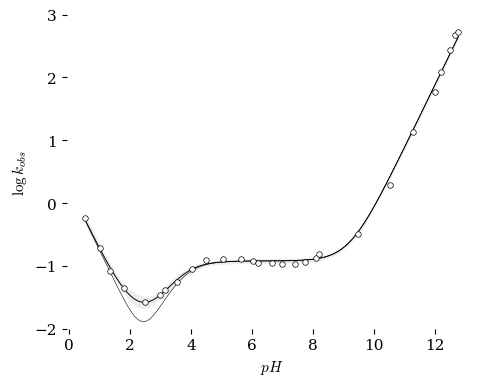

In [32]:
### The Big Curve Fit

KW = 10**(-14.0)
#KW = 10**(-14.26172)    # Kw at 17 deg C. See bottom of this notebook for more info.

################################################################################
### Function that defines the model - used in curve fit
################################################################################

def model(pH, ka = 1.88, kb=0.01, kc = 0.119, kd = 7970, Ka1 = 10**(-3.55)):    
    """
    model(x, ka, kb, kc, kd, Ka2, Ka1)
    pH is an array of pH values
    returns an array of log(k_obs) values
    """
    H = 10**(-pH)
    k_obs = (ka*(H) + kb + kc*(Ka1/H) + kd*(Ka1/H)*(KW/H))/(1 + (Ka1/H))
    return(np.log10(k_obs))

################################################################################
### Same function again but using uncertainties package - used to calc confidence band
################################################################################

def model_u(pH, ka = 1.88, kb=0.01, kc = 0.119, kd = 7970, Ka1 = 10**(-3.55)):    
    """
    model(x, ka, kb, kc, kd, Ka2, Ka1)
    pH is an array of pH values
    returns an array of log(k_obs) values
    """
    H = 10**(-pH)
    k_obs = (ka*(H) + kb + kc*(Ka1/H) + kd*(Ka1/H)*(KW/H))/(1 + (Ka1/H))
    return(unp.log10(k_obs))
                                                        
################################################################################
### Choose x and y for plot
################################################################################

x = df.index
y = df["logk"]

################################################################################
### Curve fit and extract parameters and parameters with uncertainties  
################################################################################

popt, pcov = curve_fit(model, x, y, bounds=([1.5, 0.0, .1, 7000, 10**(-4.)], [2, 1, .2, 100000, 10**(-3.)]))

popt_un = un.correlated_values(popt, pcov)

[ka, kb, kc, kd, Ka1] = popt_un   # get parameters as correlated uncertain floats

print(f"ka = {ka:0.2e}")
print(f"kb = {kb:0.2e}")
print(f"kc = {kc:0.2e}")
print(f"kd = {kd:0.2e}")
print(f"pKa = {-unp.log10(Ka1):0.2f}")

x1 = np.linspace(np.min(x), np.max(x), 100)
y1 = unp.nominal_values(model_u(x1, ka, kb, kc, kd, Ka1))
y2 = unp.nominal_values(model_u(x1, ka, 0, kc, kd, Ka1))

################################################################################
### Setup a figure with two plots side-by-side and choose a stylesheet   
################################################################################
plt.rcdefaults()
plt.style.use(github_styles_location + "tufte.mplstyle")        
#plt.style.use(github_styles_location + "S2_classic2.mplstyle")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  

################################################################################
### Plot the data and the line fit.   
################################################################################

ax.plot(x1, y1, color='black', zorder=1, linewidth=0.7)
ax.plot(x1, y2, color='black', zorder=1, linewidth=0.4)

ax.scatter(x, y, 
           marker = "o", s=16, 
           color="white", edgecolor = "black",
           linewidth = 0.5, zorder=3)

################################################################################
### Set labels and scale 
################################################################################

ax.set(ylabel=r"$\log{k_{obs}}$", 
       xlabel=r"$pH$",
#          xlim=[0,13],                  
          ylim=[-2,3]
      )

#ax.margins(x=.07, y=.07, tight=True)      # add 7% empty space around outside of plot area   


# upper and lower bounds of uncertain kobs as float values

################################################################################
### Create Confidence band upper and lower bounds
################################################################################

sigma = 2

bestfit_y1 = model_u(x1, ka, kb, kc, kd, Ka1)
dev = unp.std_devs(bestfit_y1) * sigma

fit_up = unp.nominal_values(bestfit_y1) + dev
fit_dn = unp.nominal_values(bestfit_y1) - dev

ax.fill_between(x1, fit_up, fit_dn, 
                   color="lightgray", alpha=0.4, zorder = 0,
                   linewidth=0, label="confidence interval")

#############################
### Output the final plot ###
#############################

fig.savefig("plots/03_plot_pH3_un.pdf")   # use this to save the figure in PDF format
plt.show()                 # output the combined plot plots


    

### Residual Plot

The code below will output a residual plot for the model fit above.

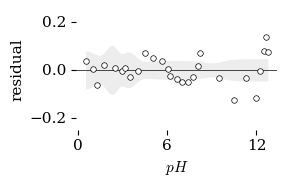

In [33]:
################################################################################
### Choose x and y for plot
################################################################################

x = df.index
y = df["logk"]

bestfitvalues = model_u(x, ka, kb, kc, kd, Ka1)

res = y - unp.nominal_values(bestfitvalues)
##################################################
### Setup a figure with two plots side-by-side ###
### and choose a stylesheet                    ###
##################################################
plt.rcdefaults()
plt.style.use(github_styles_location + "tufte.mplstyle")        
#plt.style.use(github_styles_location + "S2_classic2.mplstyle")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,2))  

#########################################
### Plot the data and the line fit.   ###
#########################################


#ax.scatter(x,y, s=32, color="white", zorder=2)
ax.scatter(x, res, 
           marker = "o", s=16, 
           color="white", edgecolor = "black",
           linewidth = 0.5, zorder=3)

    
############################
### Set labels and scale ###
############################

ax.set(ylabel=r"residual", 
       xlabel=r"$pH$",
#          xlim=[0,13],                  
          ylim=[-0.25,0.25],
          xticks = [0,6,12]
      )

#ax.margins(x=.07, y=.07, tight=True)      # add 7% empty space around outside of plot area   


# upper and lower bounds of uncertain kobs as float values

#### Create Confidence band upper and lower bounds

ax.fill_between(x1, -dev, dev, 
                   color="lightgray", alpha=0.4, zorder = 0,
                   linewidth=0, label="confidence interval")
ax.axhline(0, color = "black", linewidth = 0.5)
#############################
### Output the final plot ###
#############################

fig.savefig("plots/03_residual_plot_pH3_un.pdf")   # use this to save the figure in PDF format
plt.show()                 # output the combined plot plots


    

# Buffer Rate Plot
The code below reads the data fro the buffer rate experiment in the paper and plots the result.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import linregress
from scipy.optimize import curve_fit


################################################################################
### Read data set. The fields are separated by commas; comments are enabled  ###
################################################################################
df1 = pd.read_csv(data_path + "EdwardsBufferData.csv", 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="conc", 
                 comment = "#") 

df1["logk"] = np.log10(df1["k_obs"])
df1["logconc"] = np.log10(df1.index)

df1

,k_obs,logk,logconc
conc,,,
0.33300,0.112,-0.950782,-0.477556
0.16700,0.116,-0.935542,-0.777284
0.08330,0.114,-0.943095,-1.079355
0.04170,0.114,-0.943095,-1.379864
0.02090,0.119,-0.924453,-1.679854
0.01040,0.115,-0.939302,-1.982967
0.00521,0.119,-0.924453,-2.283162


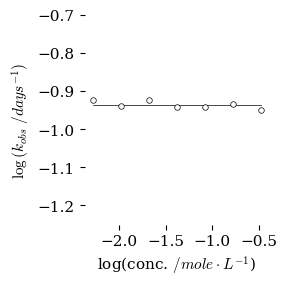

[[9.93197267e-07]] [0.11557143]


In [31]:
#x = df1["logconc"]
#y = np.array(df1["logk"])

x = df1.index
y = df1["k_obs"]


##################################################
### Setup a figure with two plots side-by-side ###
### and choose a stylesheet                    ###
##################################################

plt.style.use(github_styles_location + "tufte.mplstyle")        
#plt.style.use(github_styles_location + "S2_classic2.mplstyle")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))  

#########################################
### Plot the data and the line fit.   ###
#########################################

def zeroslope (x, int):
    return int*x/x

param, pcov = curve_fit(zeroslope, x, y)

int = param[0]
fity = 0 * x + int
ax.plot(np.log10(x), np.log10(fity), 
        color='black', linewidth=0.5,
        zorder=1, 
        )


ax.scatter(np.log10(x), np.log10(y), 
           marker = "o", s=16, 
           color="white", edgecolor = "black",
           linewidth = 0.5, zorder=3)

    
############################
### Set labels and scale ###
############################

ax.set(ylabel=r"$\log{(k_{obs}\ /days^{-1})}$", 
       xlabel=r"log(conc. ${/mole\cdot L^{-1}}$)",
#           xlim=[-0.01,0.35],                  
          ylim=[-1.25,-0.7]
      
      )

#ax.margins(x=.07, y=.07, tight=True)      # add 7% empty space around outside of plot area   

#############################
### Output the final plot ###
#############################

fig.savefig("plots/04_plot_buffer.pdf")   # use this to save the figure in PDF format
plt.show()                 # output the combined plot plots

param, pcov = curve_fit(zeroslope, x, y)
perr = np.sqrt(np.diag(pcov))
print(pcov, param)

## calculation Kw at 17 degrees

the reactions above were performed at $17\ ^\circ C$. What is the value of $K_W$ at $17\ ^\circ C$?

,temp degC,d g/cm
0,0,999.82
1,1,999.89
2,2,999.94
3,3,999.98
4,4,1000.00


log Kw at 17 deg is 17   -14.26712
Name: d g/cm, dtype: float64


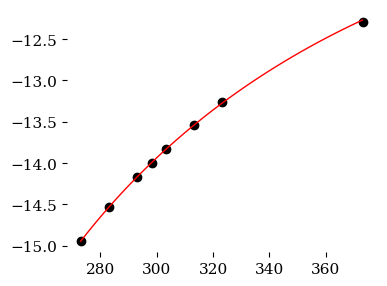

In [29]:
# https://srd.nist.gov/JPCRD/jpcrd181.pdf
# https://www.chemguide.co.uk/physical/acidbaseeqia/kw.html
# 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import linregress
from scipy.optimize import curve_fit


################################################################################
### Read data set. The fields are separated by commas; comments are enabled  ###
################################################################################
df2 = pd.read_csv("data/water_density2.csv", 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="pH", 
                 comment = "#") 
display(df2.head())


# Data from https://www.chemguide.co.uk/physical/acidbaseeqia/kw.html
T = np.array([0,10,20,25,30,40,50,100])  
T = T + 273.15
Kw = np.array([0.114e-14,
               0.293E-14,
               0.681E-14,
               1.008E-14,
               1.471E-14,
               2.916E-14,
               5.476E-14,
               51.30E-14,
           ])

plt.plot(T,np.log10(Kw), "ko")

# Empirical equation from https://srd.nist.gov/JPCRD/jpcrd181.pdf
A = -4.098
B = -3245.2
C = 2.2362E5
D = -3.984E7
E = 13.957
F = -1262.3
G = 8.5641E5

T = df2["temp degC"]+273
pw = df2["d g/cm"]/1000
logKwCalcNIST = A + B/T + C/T**2 + D/T**3 + (E + F/T + G/T**2)*np.log10(pw)
plt.plot((T),logKwCalcNIST, "r-")

T=17+273.15
line = df2.loc[df2["temp degC"]==17]
pw = line["d g/cm"]/1000

logKwCalcNIST = A + B/T + C/T**2 + D/T**3 + (E + F/T + G/T**2)*np.log10(pw)

t17 = logKwCalcNIST
print(f"log Kw at 17 deg is {t17}")

In [186]:
line = df2.loc[df["temp degC"]==17]
line["d g/cm"]

17    998.86
Name: d g/cm, dtype: float64

## Using LMFit

The below code will perform the same curve fit as above using the LMFit package rather than scipy.optimize.curve_fit. the detailed report from LMFit is advantageous and its built-in tools for calculating the fit line and the confidence band are also helpful.

[[Model]]
    Model(model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 28
    # variables        = 5
    chi-square         = 0.09112128
    reduced chi-square = 0.00396179
    Akaike info crit   = -150.377515
    Bayesian info crit = -143.716493
    R-squared          = 0.99816137
[[Variables]]
    ka:   1.74919759 +/- 0.17491563 (10.00%) (init = 1.5)
    kb:   0.01425714 +/- 0.00462650 (32.45%) (init = 0.015)
    kc:   0.11988751 +/- 0.00541013 (4.51%) (init = 0.15)
    kd:   7555.71642 +/- 405.066013 (5.36%) (init = 10000)
    Ka1:  2.2141e-04 +/- 7.1427e-05 (32.26%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kb, Ka1) = -0.7519
    C(ka, kb)  = -0.5367
    C(kc, Ka1) = -0.3910
    C(ka, Ka1) = +0.3678
    C(kb, kc)  = +0.1240
ka = (1.75+/-0.17)e+00
kb = (1.43+/-0.46)e-02
kc = (1.20+/-0.05)e-01
kd = (7.56+/-0.41)e+03
pKa = 3.65+/-0.14


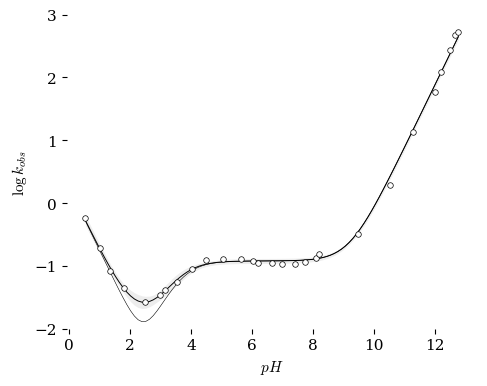

In [40]:
### The Big LMFit Curve Fit

import lmfit     

KW = 10**(-14.0)
#KW = 10**(-14.26172)    # Kw at 17 deg C. See bottom of this notebook for more info.

################################################################################
### Function that defines the model - used in curve fit
################################################################################

def model(pH, ka = 1.88, kb=0.01, kc = 0.119, kd = 7970, Ka1 = 10**(-3.55)):    
    """
    model(x, ka, kb, kc, kd, Ka2, Ka1)
    pH is an array of pH values
    returns an array of log(k_obs) values
    """
    H = 10**(-pH)
    k_obs = (ka*(H) + kb + kc*(Ka1/H) + kd*(Ka1/H)*(KW/H))/(1 + (Ka1/H))
    return(np.log10(k_obs))
                                                        
################################################################################
### Choose x and y for plot
################################################################################

x = df.index
y = df["logk"]

################################################################################
### Curve fit and extract parameters and parameters with uncertainties  
################################################################################

mod = lmfit.Model(model, nan_policy = 'omit')  # load the function f as the model to be fit

                                    # state the parameters (use the text strings that we used above in sympy)
pars = mod.make_params(ka = dict(value = 1.5, min = 1E-15),
                       kb = dict(value = 0.015, min = 1E-15),
                       kc = dict(value = 0.15, min = 1E-15),
                       kd = dict(value = 10000, min = 1, max = 100000),
                       Ka1 = dict(value = 10**-4., min = 10*-10, max = 10**-1),
                       )    # initial values are also set here
                                    
result = mod.fit(y, pars, pH=x,
            #     weights = 1/ys
                 )  # Use the .fit method on the model object to perform the curve fit
                                # the variable in this function is 't' so we must use that in the call
##########################
### get the results 
##########################

print(result.fit_report())


ka = result.uvars['ka']
kb = result.uvars['kb']
kc = result.uvars['kc']
kd = result.uvars['kd']
Ka1 = result.uvars['Ka1']
























print(f"ka = {ka:0.2e}")
print(f"kb = {kb:0.2e}")
print(f"kc = {kc:0.2e}")
print(f"kd = {kd:0.2e}")
print(f"pKa = {-unp.log10(Ka1):0.2f}")

x1 = np.linspace(np.min(x), np.max(x), 100)
y1 = unp.nominal_values(model_u(x1, ka, kb, kc, kd, Ka1))
y2 = unp.nominal_values(model_u(x1, ka, 0, kc, kd, Ka1))

################################################################################
### Setup a figure with two plots side-by-side and choose a stylesheet   
################################################################################
plt.rcdefaults()
plt.style.use(github_styles_location + "tufte.mplstyle")        
#plt.style.use(github_styles_location + "S2_classic2.mplstyle")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  

################################################################################
### Plot the data and the line fit.   
################################################################################

ax.plot(x1, y1, color='black', zorder=1, linewidth=0.7)
ax.plot(x1, y2, color='black', zorder=1, linewidth=0.4)

ax.scatter(x, y, 
           marker = "o", s=16, 
           color="white", edgecolor = "black",
           linewidth = 0.5, zorder=3)

################################################################################
### Set labels and scale 
################################################################################

ax.set(ylabel=r"$\log{k_{obs}}$", 
       xlabel=r"$pH$",
#          xlim=[0,13],                  
          ylim=[-2,3]
      )

#ax.margins(x=.07, y=.07, tight=True)      # add 7% empty space around outside of plot area   


# upper and lower bounds of uncertain kobs as float values

################################################################################
### Create Confidence band upper and lower bounds
################################################################################

sigma = 2

bestfit_y1 = model_u(x1, ka, kb, kc, kd, Ka1)
dev = unp.std_devs(bestfit_y1) * sigma

fit_up = unp.nominal_values(bestfit_y1) + dev
fit_dn = unp.nominal_values(bestfit_y1) - dev

ax.fill_between(x1, fit_up, fit_dn, 
                   color="lightgray", alpha=0.4, zorder = 0,
                   linewidth=0, label="confidence interval")

#############################
### Output the final plot ###
#############################

fig.savefig("plots/03_plot_pH3_un.pdf")   # use this to save the figure in PDF format
plt.show()                 # output the combined plot plots


    